In [8]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet,HierarchicalBorelSets
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
import torch 
import pandas as pd
import geopandas
import numpy as np 
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
from stpy.point_processes.poisson.poisson import PoissonPointProcess
from sensepy.capture_thompson import CaptureThompson
import time
from utils import *

In [9]:
estimator = PoissonRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=8
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=KernelFunction(kernel_name="squared_exponential", gamma=0.12, d=2),
    max_intensity=10.0e10,  # maximal value of the rate function
    min_intensity=0.1,  # minimal value of the rate function
    basis_size_per_dim=10,  # number of basis functions along each axis
    jitter=10e-3,
    langevine_sampling_steps=200,  # langevin steps for sampling,
    estimator="least-sq",
    optimization_library="cvxpy",
)

Precomputing phis.
Precomputation finished.


In [10]:
name = "sensepy/sensepy/benchmarks/data/taxi_data.csv"
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.Tensor([[-1.0, 1.0], [-1, 1]]).double())
data, gdf = get_taxi_data(200, D)

In [11]:
# load data in the above format
st = time.process_time()
estimator.load_data(data)
et = time.process_time()
print("Time to load data: ", et - st)

Time to load data:  3.8507076999999867


In [12]:
# fit the Cox process by calculating MAP. Method is defined by estimator.estimator
# it is set to penalized_likelihood, so we do the posterior GP approximation by
# the sensing paper. Also estimator.feedback is set to count-record so no histogram
# By default dual = True which means that data is split into buckets that
# are given by the quadtree
estimator.dual = True
st = time.process_time()
estimator.fit_gp()
et = time.process_time()
print("Time to fit GP: ", et - st)

/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/cvxpy/reductions/solvers/conic_solvers/mosek_conif.py:654: UserWarning: 
Using MOSEK constants to specify parameters is deprecated.
Use generic string names instead.
For example, replace mosek.iparam.num_threads with 'MSK_IPAR_NUM_THREADS'

  warnings.warn(__MSK_ENUM_PARAM_DEPRECATION__, UserWarning)


optimal
Time to fit GP:  5.664820399999996


In [13]:
left, down, right, up = gdf.total_bounds

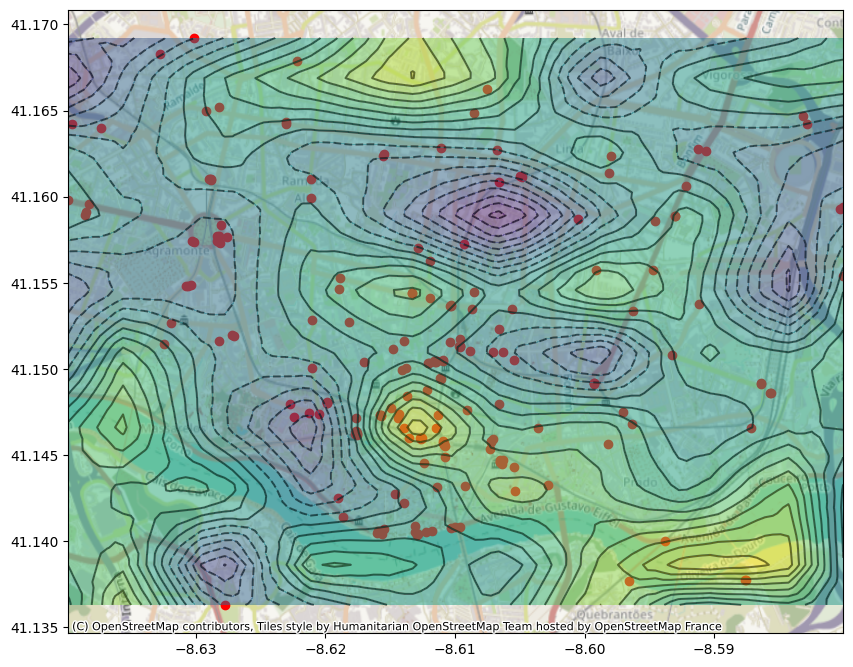

In [14]:
# Plotting the fitted Map
n = 30  # discretization
xtest = D.return_discretization(n)
Map = BorelSet(d=2, bounds=torch.Tensor([[left, right], [down, up]]).double())
xtest_orig = Map.return_discretization(n).numpy()

f = estimator.rate_value(xtest)

xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

grid_x, grid_y = np.mgrid[min(xx) : max(xx) : 100j, min(yy) : max(yy) : 100j]
grid_z_f = griddata(
    (xx, yy), f[:, 0].detach().numpy(), (grid_x, grid_y), method="linear"
)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="red", figsize=(10, 10))
cs = ax.contourf(grid_x, grid_y, grid_z_f, levels=20, alpha=0.5)
ax.contour(cs, colors="k", alpha=0.5)
ctx.add_basemap(ax, crs=gdf.crs.to_string())
plt.show()